(100, 1231, 3) (100, 1231, 2)
50
1231
3
2
Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 1.8523 - val_loss: 1.5894
Epoch 2/1000
1/1 [==============================] - 0s 427ms/step - loss: 1.5872 - val_loss: 1.4049
Epoch 3/1000
1/1 [==============================] - 0s 428ms/step - loss: 1.4036 - val_loss: 1.2636
Epoch 4/1000
1/1 [==============================] - 0s 462ms/step - loss: 1.2625 - val_loss: 1.1535
Epoch 5/1000
1/1 [==============================] - 0s 407ms/step - loss: 1.1522 - val_loss: 1.0626
Epoch 6/1000
1/1 [==============================] - 0s 408ms/step - loss: 1.0620 - val_loss: 0.9844
Epoch 7/1000
1/1 [==============================] - 0s 411ms/step - loss: 0.9839 - val_loss: 0.9128
Epoch 8/1000
1/1 [==============================] - 0s 401ms/step - loss: 0.9123 - val_loss: 0.8456
Epoch 9/1000
1/1 [==============================] - 0s 414ms/step - loss: 0.8452 - val_loss: 0.7866
Epoch 10/1000
1/1 [==============================] - 0s 433ms

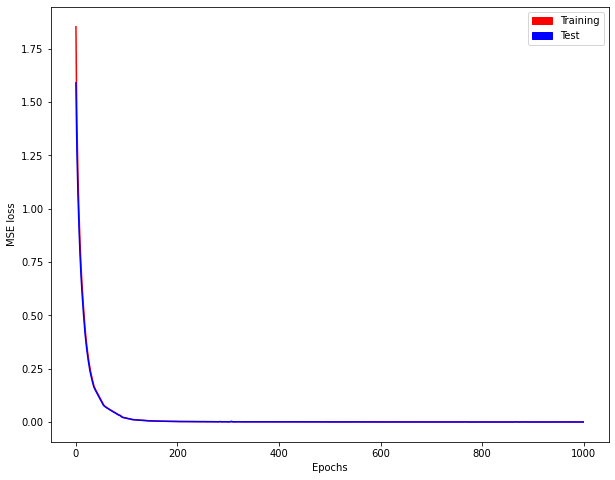

(1231, 3)
(1231, 2)
[[ 0.0823483   0.05626965]
 [ 0.26835072  0.01806916]
 [ 0.344311   -0.00961782]
 ...
 [ 1.0111005  -0.00464261]
 [ 1.0107812  -0.00484602]
 [ 1.009591   -0.00551185]]


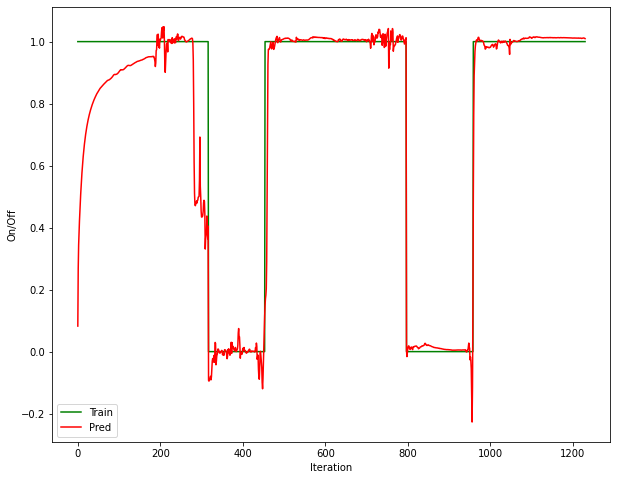

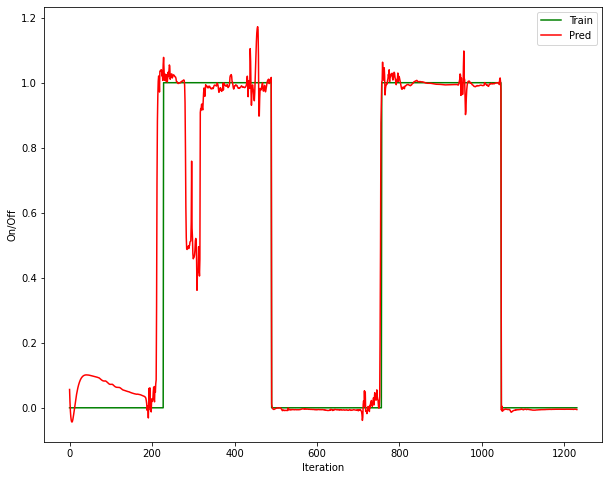

In [1]:
# Multioutput Regression Example with Keras LSTM Network in Python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


AllData = pd.read_excel('2021.8.25 ML.xlsx','Sheet3')
AllData['SC1'] = AllData['SC1'].map({'Yes':1,'No':0})
AllData['SC2'] = AllData['SC2'].map({'Yes':1,'No':0})
def random_sample(len_timeseries=1231):
  Nchoice = 600
x1 = AllData.iloc[:,1]
x2 = AllData.iloc[:,2]
x3 = AllData.iloc[:,3]
y1 = AllData.iloc[:,4]
y2 = AllData.iloc[:,5]
X = np.array([x1,x2,x3]).T
y = np.array([y1,y2]).T

def generate_data(Nsequence = 1000):
    X_train = []
    y_train = []
    for isequence in range(Nsequence):
       # y, X = random_sample()
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

Nsequence = 100
prop = 0.5
Ntrain = int(Nsequence*prop)
X, y = generate_data(Nsequence)
X_train = X[:Ntrain,:,:]
X_test  = X[Ntrain:,:,:]
y_train = y[:Ntrain,:,:]
y_test  = y[Ntrain:,:,:] 

#X.shape = (N sequence, length of time series, N input features)
#y.shape = (N sequence, length of time series, N targets)
print(X.shape, y.shape)
# (100, 1231, 3) (100, 1234, 2)

# Cutting function #

def stateful_cut(arr, batch_size, T_after_cut):
    if len(arr.shape) != 3:
        # N: Independent sample size,
        # T: Time length,
        # m: Dimension
        print("ERROR: please format arr as a (N, T, m) array.")

    N = arr.shape[0]
    T = arr.shape[1]

    # We need T_after_cut * nb_cuts = T
    nb_cuts = int(T / T_after_cut)
    if nb_cuts * T_after_cut != T:
        print("ERROR: T_after_cut must divide T")

    # We need batch_size * nb_reset = N
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset
    nb_reset = int(N / batch_size)
    if nb_reset * batch_size != N:
        print("ERROR: batch_size must divide N")

    # Cutting (technical)
    cut1 = np.split(arr, nb_reset, axis=0)
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1]
    cut3 = [np.concatenate(x) for x in cut2]
    cut4 = np.concatenate(cut3)
    return(cut4)

# Main code #

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Data ##
N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 100 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = [X_train, y_train, X_test, y_test]

print(N)
print(T)
print(dim_in)
print(dim_out)



# Model ##
nb_units = 20
model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=True, units=nb_units, stateful=True))
model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

# Training ##

epochs = 1000

nb_reset = int(N / batch_size)
if nb_reset > 1:
    print("ERROR: We need to reset states when batch_size < N")

# When nb_reset = 1, we do not need to reinitialize states
history = model.fit(inputs, outputs, epochs = epochs, 
                    batch_size = batch_size, shuffle=False,
                    validation_data=(inputs_test, outputs_test))

def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpatches.Patch(color='red', label='Training')
    blue_patch = mpatches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss


##
# Visual checking for a time series
##
## Mime model which is stateless but containing stateful weights
model_stateless = Sequential()
model_stateless.add(LSTM(input_shape=(None, dim_in),
               return_sequences=True, units=nb_units))
model_stateless.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model_stateless.compile(loss = 'mse', optimizer = 'rmsprop')
model_stateless.set_weights(model.get_weights())


## Prediction of a new set
i = 0 # time series selected (between 0 and N-1)
x = X_train[i]
y = y_train[i]
y_hat = model_stateless.predict(np.array([x]))[0]

print(x.shape)
print(y.shape)
print(y_hat)

for dim in range(2): # dim = 0 for y1 ; dim = 1 for y2.
    plt.figure(figsize=(10,8))
    plt.plot(range(T), y[:,dim], label ='Train', color = 'green')
    plt.plot(range(T), y_hat[:,dim], label = 'Pred', color = 'red')
    plt.xlabel('Iteration')
    plt.ylabel('On/Off')
    plt.legend()
    plt.show()

## Conclusion: works almost perfectly.